In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Google BigQuery SQL to get the blocks mined around a timestamp
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# SELECT * FROM `bigquery-public-data.crypto_ethereum.blocks`
# WHERE timestamp > "2021-02-21 23:59:30"
# and timestamp < "2021-02-22 00:00:30"
# order by timestamp

In [2]:
REALTIME_ESTIMATOR = False
# set the window of blocks, will be overwritten if REALTIME_ESTIMATOR == True
WEEK = 38
START_BLOCK = 11857946
END_BLOCK = 11903479
# we can hard code latest gov proposal if we want
latest_gov_proposal = ''
gov_factor = 1.1

In [3]:
import time
import os
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2021-02-22 17:38:07


In [4]:
from google.cloud import bigquery
import warnings


if REALTIME_ESTIMATOR:
    warnings.warn('Running realtime estimator')
    
    from urllib.request import urlopen
    import json
    url = 'https://ipfs.fleek.co/ipns/balancer-team-bucket.storage.fleek.co/balancer-claim/snapshot'
    jsonurl = urlopen(url)
    claims = json.loads(jsonurl.read())
    claimable_weeks = [20+int(w) for w in claims.keys()]
    most_recent_week = max(claimable_weeks)
    # delete the estimates for the most recent published week, since now there's an official value available on IPFS
    project_id = os.environ['GCP_PROJECT']
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.pool_estimates
        WHERE week = {most_recent_week}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result()
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.lp_estimates
        WHERE week = {most_recent_week}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result()
    
    
    from datetime import datetime
    week_1_start = '01/06/2020 00:00:00 UTC'
    week_1_start = datetime.strptime(week_1_start, '%d/%m/%Y %H:%M:%S %Z')
    WEEK = int(1 + (datetime.utcnow() - week_1_start).days/7)  # this is what week we're actually in
    
    # get all blocks of the first hour of this week to determine the first block of the week
    sql = '''
    SELECT number FROM `bigquery-public-data.crypto_ethereum.blocks`
    where timestamp >= TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), WEEK(MONDAY))
    and timestamp <= TIMESTAMP_ADD(TIMESTAMP_TRUNC(CURRENT_TIMESTAMP(), WEEK(MONDAY)), interval 1 HOUR)
    order by timestamp
    limit 1
    '''
    results = bigquery.Client().query(sql).result()
    for row in results:
        START_BLOCK = row.number

    sql = '''
    SELECT MAX(number) as number FROM `bigquery-public-data.crypto_ethereum.blocks`
    '''
    results = bigquery.Client().query(sql).result()
    for row in results:
        END_BLOCK = row.number

In [5]:
from web3 import Web3
import os
web3_provider = os.environ['ENDPOINT_URL']
w3 = Web3(Web3.WebsocketProvider(web3_provider))
start_block_timestamp = w3.eth.getBlock(START_BLOCK).timestamp
end_block_timestamp = w3.eth.getBlock(END_BLOCK).timestamp

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [6]:
import json
import requests
import pandas as pd

# the realtime estimator overrides the hard coded gov proposal
if REALTIME_ESTIMATOR:
    latest_gov_proposal = ''

# if not explicitly set, try to get the latest gov proposal from the snapshot API
if gov_factor > 1 and not latest_gov_proposal:
    space_url = 'https://hub.snapshot.page/api/spaces/balancer'
    members = json.loads(requests.get(space_url).content).get('members')

    proposals_url = 'https://hub.snapshot.page/api/balancer/proposals'
    proposals = pd.DataFrame(json.loads(requests.get(proposals_url).content)).transpose()
    # only official proposals count
    proposals = proposals[proposals['address'].isin(members)]
    proposals['end'] = proposals['msg'].apply(lambda x: x['payload'].get('end',0))
    # only proposals that ended before the beginning of the current week count
    proposals = proposals[proposals['end'] < start_block_timestamp]
    latest_gov_proposals = proposals[proposals['end']==proposals['end'].max()]
    for i,p in latest_gov_proposals.iterrows():
        print(f'Most recent governance proposal: {i}')
        print(f"Title: {p['msg']['payload'].get('name',0)}")

Most recent governance proposal: QmPvwgUBWVVAxYnPD8cBfe3NUgfWCo32kiYQUkMF2Ktc3n
Title: [Proposal] Increase AAVE capTier from cap3 to cap4 ($10M -> $30M)
Most recent governance proposal: QmYBJH6jgHhkwgspqxuk3K9uNCoJTGZqV9fdVtEWSv8eFC
Title: [Proposal] Increase TEL capTier from cap1 to cap2 ($1M -> $3M)


In [7]:
# get list of tokens eligible for liquidity mining
if REALTIME_ESTIMATOR:
    whitelist_df = pd.read_json('https://raw.githubusercontent.com/balancer-labs/assets/master/lists/eligible.json')
else:
    whitelist_df = pd.read_json(f'https://raw.githubusercontent.com/balancer-labs/assets/w{WEEK}/lists/eligible.json')

In [8]:
from urllib.request import urlopen
import json5 as json
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/blacklisted_sharelholders.json'
    jsonurl = urlopen(url)
    BLACKLISTED_SHAREHOLDERS = json.loads(jsonurl.read())['address']

    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/equivalent_sets.json5'
    jsonurl = urlopen(url)
    EQUIVALENT_SETS = json.loads(jsonurl.read())['sets']
else:
    BLACKLISTED_SHAREHOLDERS = json.load(open('config/blacklisted_sharelholders.json'))['address']
    EQUIVALENT_SETS = json.load(open('config/equivalent_sets.json5'))['sets']
    
BLACKLISTED_SHAREHOLDERS_lower = [x.lower() for x in BLACKLISTED_SHAREHOLDERS]

In [9]:
BAL_TOKEN = '0xba100000625a3754423978a60c9317c58a424e3D'
SNAPSHOT_WINDOW_SIZE = 256
CLAIM_PRECISION = 18 # leave out of results addresses that mined less than CLAIM_THRESHOLD BAL
CLAIM_THRESHOLD = 10**(-CLAIM_PRECISION)
WEEKLY_MINED = 145000
LIQUIDITY_STAKING = 45000
if REALTIME_ESTIMATOR:
    week_passed = (end_block_timestamp - start_block_timestamp)/(7*24*3600)
    WEEKLY_MINED = int(WEEKLY_MINED*week_passed)
    LIQUIDITY_STAKING = int(LIQUIDITY_STAKING*week_passed)
STAKERS_SHARE = LIQUIDITY_STAKING / WEEKLY_MINED
reports_dir = f'reports/{WEEK}'

In [10]:
import os
if not os.path.exists(reports_dir):
    os.mkdir(reports_dir)

In [11]:
import numpy as np

flatten_list = lambda t: [item for sublist in t for item in sublist]

def get_wrap_factor_of_pair(a, b):
    a = Web3.toChecksumAddress(a)
    b = Web3.toChecksumAddress(b)
    for soft in EQUIVALENT_SETS:
        for hard in soft:
            if a in hard and b in hard:
                return .1
        flat = flatten_list(soft)
        if a in flat and b in flat:
            return .2
    return 1


def get_wrap_factor(tokens_weights):
    length = len(tokens_weights)
    shape = (length, length)
    wf_matrix = np.zeros(shape)
    tokens = tokens_weights.index.get_level_values('token_address')
    for i in range(len(tokens_weights)-1):
        for j in range(i+1, len(tokens_weights)):
            wf_matrix[i,j] = wf_matrix[i,j] + get_wrap_factor_of_pair(tokens[i],tokens[j])
    weights_vector = np.array(tokens_weights)
    weights_matrix = np.outer(weights_vector,weights_vector.T)
    try:
        element_wise_product = weights_matrix * wf_matrix
    except:
        print(tokens_weights)
        print(weights_matrix)
        print(wf_matrix)
        raise
    return element_wise_product.sum()/np.triu(weights_matrix, k=1).sum()

In [12]:
def get_staking_boosts_of_pair(a, b, bal_multiplier=1):
    a = Web3.toChecksumAddress(a)
    b = Web3.toChecksumAddress(b)
    if a==BAL_TOKEN:
        cap_b = whitelist_df.loc[b.lower(),'cap']
        if cap_b == np.inf:
            return (bal_multiplier, 1)
        else:
            return (1, 1)
    elif b==BAL_TOKEN:
        cap_a = whitelist_df.loc[a.lower(),'cap']
        if cap_a == np.inf:
            return (1, bal_multiplier)
        else:
            return (1, 1)
    else:
        return (1, 1)


def get_BRF(tokens_weights, bal_multiplier=1):
    if type(bal_multiplier) != int: # expect a series of BAL multipliers on the third pass
        block_number = tokens_weights.index.get_level_values('block_number').drop_duplicates().values
        if len(block_number)>1:
            raise Exception('got more than one block_number {}'.format(block_number))
        else:
            bal_multiplier = final_bal_multiplier[block_number[0]]
            
    if 'shareholders_subpool' in tokens_weights.index.names:
        if tokens_weights.index.get_level_values('shareholders_subpool').all():
            bal_multiplier=1
    else:
        if tokens_weights.index.nlevels==4:
            raise Exception('shareholders_subpool not in index')    
            
    denominator = 0
    numerator = 0
    token_address = list(tokens_weights.index.get_level_values('token_address'))
    token_weights = list(tokens_weights)
    for i in range(len(tokens_weights)-1):
        for j in range(i+1, len(tokens_weights)):
            token_A = token_address[i]
            token_B = token_address[j]
            weight_A = token_weights[i]
            weight_B = token_weights[j]
            staking_boosts = get_staking_boosts_of_pair(token_A, token_B, bal_multiplier)
            staking_boost_A = staking_boosts[0]
            staking_boost_B = staking_boosts[1]
            staking_boost_of_pair = (staking_boost_A * weight_A + staking_boost_B * weight_B) / (weight_A + weight_B)
            
            ratio_factor = 4 * (weight_A / (weight_A + weight_B)) * (weight_B / (weight_A + weight_B))
            
            numerator += staking_boost_of_pair * ratio_factor * weight_A * weight_B
            denominator += weight_A * weight_B
    return numerator/denominator

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

In [14]:
from tqdm.auto import tqdm
def get_list_of_snapshot_blocks(start, end):
    block_list = range(end, start, -SNAPSHOT_WINDOW_SIZE)
    block_list = list(block_list)
    block_list.sort()
    return block_list

snapshot_blocks = get_list_of_snapshot_blocks(START_BLOCK, END_BLOCK)
snapshot_timestamps_blocks = {w3.eth.getBlock(b).timestamp: b \
                              for b in tqdm(snapshot_blocks, 'Getting snapshot timestamps')}
snapshot_blocks_timestamps = {v: k for k,v in snapshot_timestamps_blocks.items()}
snapshot_blocks_as_str = [str(b) for b in snapshot_blocks]
print('week {}: {} snapshot blocks'.format(WEEK, len(snapshot_blocks)))
print('week {}: first snapshot block: {} ({}...)'.format(WEEK, min(snapshot_blocks), snapshot_blocks[:3]))
print('week {}: last snapshot block: {} (...{})'.format(WEEK, max(snapshot_blocks), snapshot_blocks[-3:]))


week 38: 178 snapshot blocks
week 38: first snapshot block: 11858167 ([11858167, 11858423, 11858679]...)
week 38: last snapshot block: 11903479 (...[11902967, 11903223, 11903479])


In [15]:
# remove kovan
whitelist_df.drop(columns=['kovan'], inplace=True)
whitelist_df.dropna(inplace=True)
# convert string to cap
whitelist_df.rename(columns={'homestead':'cap'}, inplace=True)
CAP_TIERS = {
    'cap1':   1e6,
    'cap2':   3e6,
    'cap3':  10e6,
    'cap4':  30e6,
    'cap5': 100e6,
    'uncapped': np.inf,
}
whitelist_df['cap'] = whitelist_df['cap'].apply(lambda x: CAP_TIERS[x])
# lower case the token addresses for later join
whitelist_df.index.name = 'checksum_token_address'
whitelist_df.reset_index(inplace=True)
whitelist_df['checksum_token_address'] = whitelist_df['checksum_token_address'].apply(Web3.toChecksumAddress)
whitelist_df.set_index(whitelist_df['checksum_token_address'].str.lower(), inplace=True)
whitelist_df.index.name = 'token_address'

In [16]:
# get decimals of whitelisted tokens
import json
from web3.exceptions import ABIFunctionNotFound, BadFunctionCallOutput, InvalidAddress
token_abi = json.load(open('abi/BToken.json'))
def get_token_decimals(token_address):
    if token_address == '0x0Ba45A8b5d5575935B8158a88C631E9F9C95a2e5':
        return 18
    if token_address == '0xE0B7927c4aF23765Cb51314A0E0521A9645F0E2A':
        return 9
    try:
        token_contract = w3.eth.contract(token_address, abi=token_abi)
    except InvalidAddress:
        print('Invalid Address: ' + token_address)
        raise
    try:
        return token_contract.functions.decimals().call()
    except ABIFunctionNotFound:
        print(f'{token_address} does not implement decimals(), assuming 0')
        return 0
    except BadFunctionCallOutput:
        print(f'{token_address}: decimals() returned bad output, assuming 0')
        return 0
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Getting token decimals from ethereum node...')
whitelist_df['decimals'] = whitelist_df['checksum_token_address'].apply(get_token_decimals)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')

2021-02-22 17:38:49 - Getting token decimals from ethereum node...
2021-02-22 17:40:08 - Done!


In [17]:
# get USD prices of whitelist tokens
import requests
from time import sleep
from tqdm.auto import tqdm
import json


if REALTIME_ESTIMATOR:
    prices_json = {}
else:
    try:
        prices_json = json.load(open(reports_dir+'/_prices.json'))
    except FileNotFoundError:
        prices_json = {}

MARKET_API_URL = 'https://api.coingecko.com/api/v3'
price_query = MARKET_API_URL+'/coins/ethereum/contract/{}/market_chart/range?&vs_currency=usd&from={}&to={}'
time_bounded_price_query = price_query.format('{}', start_block_timestamp, end_block_timestamp)
whitelist_df['prices_api_response'] = ''
whitelist_df['prices_dict'] = ''
for i in tqdm(whitelist_df.index, 'Getting prices'):
    checksum_token_address = whitelist_df.loc[i,'checksum_token_address']
    query_url = time_bounded_price_query.format(checksum_token_address)
    # when running week 26 we ran across a bug in Coingecko price feed where the price of WETH was reported as 0
    # price of ETH is unaffected, so using it instead
    if '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2' in query_url:
        query_url = query_url.replace('/contract/0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2','')
    prices_dict = {'prices': prices_json.get(checksum_token_address, None)}
    if prices_dict['prices'] is None:
        prices_dict = None
    tries = 0
    while prices_dict is None:
        token_prices = requests.get(query_url)
        try:
            prices_dict = json.loads(token_prices.content)
        except:
            pass
        # sleep for one second to avoid being blocked
        sleep(1)
        tries += 1
        if tries > 5:
            break
        whitelist_df.loc[i,'prices_api_response'] = token_prices.content
    whitelist_df.loc[i,'prices_dict'] = [prices_dict]

In [18]:
import json

tokens_not_found = whitelist_df[whitelist_df['prices_dict'].apply(lambda x: 'error' in x.keys())].index
whitelist_df.drop(index=tokens_not_found, inplace=True)
print('Tokens not found in Coingecko: {}'.format(list(tokens_not_found)))

whitelist_df['prices_lists'] = whitelist_df['prices_dict'].apply(lambda x: x.get('prices'))
prices_not_found = whitelist_df[whitelist_df['prices_lists'].apply(lambda x: len(x)==0)].index
whitelist_df.drop(index=prices_not_found, inplace=True)
print('Prices not found in Coingecko for: {}'.format(list(prices_not_found)))

exploded_whitelist_df = whitelist_df.explode('prices_lists').dropna()
exploded_whitelist_df.reset_index(inplace=True)
exploded_whitelist_df[['timestamp','price']] = pd.DataFrame(exploded_whitelist_df.prices_lists.tolist(), index=exploded_whitelist_df.index)

prices_df = exploded_whitelist_df[['token_address', 'checksum_token_address', 'cap', 'timestamp', 'price']].copy()

prices_df['ts_price'] = prices_df.apply(lambda x: [x['timestamp'], x['price']], axis=1)

if not REALTIME_ESTIMATOR:
    prices_df.groupby('checksum_token_address').agg(list)['ts_price'].to_json(reports_dir+'/_prices.json',
                                                                 orient='index',
                                                                 indent=4
                                                                )

prices_df['timestamp'] = prices_df['timestamp']//1000

Tokens not found in Coingecko: ['0x0c6f5f7d555e7518f6841a79436bd2b1eef03381', '0xa7ed29b253d8b4e3109ce07c80fc570f81b63696']
Prices not found in Coingecko for: ['0x9a48bd0ec040ea4f1d3147c025cd4076a2e71e3e', '0x3a3a65aab0dd2a17e3f1947ba16138cd37d08c04', '0x7d2d3688df45ce7c552e19c27e007673da9204b8', '0x71010a9d003445ac60c4e6a7017c1e89a477b438', '0xc7d79021cd127a2f35b1e26fe3c4aad67f5c28b8', '0x54355ae0485f9420e6ce4c00c10172dc8e5728a3', '0x07509c281b55a1675d3f71f1c4ab67829eb731d3', '0x0bf54992649c19bd8db4080078a32383827352f3', '0xf43b2f981efc5a611a97951ce4fd7d3bd87f4902', '0x48ac44f4e29e602f851b84c271c22b85b9447251', '0xc7088fac73c55bfae5c2a963c3029b072c7dff25', '0x2409d6059e2a8130c099e49f3cb418fd6c3d9aff', '0xd218d75ba0fc45858a4e9ef57a257ed9977db5f4', '0xbddd682e63dd9f9fa3b97aea88772e77cf3e5013', '0x78481fb80caabb252909218164266ac83f815000', '0x1003ec54f51565ff86ac611184ea23d6310cae71', '0xabc754ac2161b557d28062f41dcc0fc18440ac7e', '0xa360f2af3f957906468c0fd7526391aed08ae3db', '0x1bcca39ae

In [19]:
# get eligible token balances of every balancer pool at every snapshot block from Big Query
get_pools_sql = '''
SELECT pool FROM `blockchain-etl.ethereum_balancer.BFactory_event_LOG_NEW_POOL` 
'''

sql = """
select * from `blockchain-etl.ethereum_balancer.view_token_balances_subset`
where token_address in (\'{0}\')
and address in ({1})
and token_address not in ('0xd46ba6d942050d489dbd938a2c909a5d5039a161')
and block_number in ({2})
and balance > 0

union all

select '0xd46ba6d942050d489dbd938a2c909a5d5039a161' as token_address,
* from `blockchain-etl.ethereum_balancer.view_token_balances_subset_AMPL`
where address in ({1})
and block_number in ({2})
and balance > 0

""".format('\',\''.join(whitelist_df.index), # only get balances of tokens for which there is a price feed
           get_pools_sql, 
           ','.join(snapshot_blocks_as_str))
# print(sql)

In [20]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying BigQuery...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
pools_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
n = len(pools_balances)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Done ({n} records)')

2021-02-22 17:41:37 - Querying BigQuery...
2021-02-22 17:42:57 - Done (732057 records)


In [21]:
pools_balances['scaled_balance'] = pools_balances['balance'] * pools_balances.join(whitelist_df['decimals'], on='token_address')['decimals'].apply(lambda x: 10**(-x))
pools_balances['timestamp'] = pools_balances['block_number'].apply(lambda x: snapshot_blocks_timestamps[x])

In [22]:
pools_balances.set_index(['address','block_number','token_address'], inplace=True)
number_of_liquid_eligible_tokens = pools_balances.groupby(['address','block_number']).size()
number_of_liquid_eligible_tokens.name = 'number_of_liquid_eligible_tokens'
pools_balances = pools_balances.join(number_of_liquid_eligible_tokens)
eligible_pools_balances = pools_balances[pools_balances['number_of_liquid_eligible_tokens']>=2].copy()
eligible_pools_balances.reset_index(inplace=True)

In [23]:
# merge balances and prices datasets on nearest timestamp, and compute USD balance of each token in each pool at each block
usd_pools_balances = pd.merge_asof(eligible_pools_balances.sort_values(by='timestamp'), 
                                   prices_df.sort_values(by='timestamp'), 
                                   on='timestamp', by='token_address', direction='nearest')
usd_pools_balances['usd_balance'] = usd_pools_balances['scaled_balance'] * usd_pools_balances['price']

In [24]:
# get token weights and swap fees of pools with public swap enabled
sql = """
select W.*, COALESCE(swapFee,'1000000000000') as swapfee
from `blockchain-etl.ethereum_balancer.view_pools_tokens_denorm_weights` W
left join `blockchain-etl.ethereum_balancer.view_pools_fees` F
on W.address = F.address and W.block_number = F.block_number
left join `blockchain-etl.ethereum_balancer.view_pools_public_swaps` S
on W.address = S.address and W.block_number = S.block_number
where COALESCE(public_,'false') = 'true'
and W.denorm > 0
and token_address in (\'{}\')
and W.address in ('{}')
and W.block_number in ({})
""".format('\',\''.join(whitelist_df.index), # only get weights of tokens for which there is a price feed
           '\',\''.join(eligible_pools_balances['address'].drop_duplicates()), 
           ','.join(snapshot_blocks_as_str))
# print(sql)

In [25]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying BigQuery...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
pools_weights = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
n = len(pools_weights)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Done ({n} records)')

2021-02-22 17:43:09 - Querying BigQuery...
2021-02-22 17:45:52 - Done (616403 records)


In [26]:
# the merge removes records associated with balances of tokens that are not part of the pool
pools_weights_balances = pools_weights.merge(usd_pools_balances, 
                                             on=['address', 'token_address', 'block_number'],
                                             how='inner')
pools_weights_balances.set_index(['address', 'token_address', 'block_number'], inplace=True)
pools_weights_balances['denorm'] = pools_weights_balances['denorm'].apply(float)
summed_weights = pools_weights_balances['denorm'].groupby(['address','block_number']).sum()
norm_weights = pools_weights_balances['denorm'] / summed_weights
norm_weights.name = 'norm_weights'
pools_weights_balances = pools_weights_balances.join(norm_weights)
# remove pools with only one eligible token
pools_weights_balances = pools_weights_balances[pools_weights_balances['norm_weights']<1]

In [27]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Computing wrap factor...')
wrap_factor = pools_weights_balances['norm_weights'].\
                    groupby(['address','block_number']).\
                    agg(get_wrap_factor)
wrap_factor.name = 'wrap_factor'
pools_weights_balances = pools_weights_balances.join(wrap_factor)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2021-02-22 17:45:57 - Computing wrap factor...
2021-02-22 17:49:58 - Done


In [28]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Computing BRF (first pass)...')
brf = pools_weights_balances['norm_weights']. \
                groupby(['address','block_number']). \
                agg(get_BRF)
brf.name = 'first_pass_brf'
pools_weights_balances = pools_weights_balances.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2021-02-22 17:49:58 - Computing BRF (first pass)...
2021-02-22 17:52:33 - Done


In [29]:
# compute the fee factor
# https://forum.balancer.finance/t/modifying-feefactor-toward-reducing-the-mining-penalty-for-high-fee-pools/103
# a swapfee of 1% is stored in the smart contracts as 1e+16 (0.01e+18)
# fee factor formula as defined in the specs above takes as argument the fee as a percentage (eg 1 for a fee of 1% - not 0.01)
pools_weights_balances['fee_factor'] = np.exp(-(0.25 * \
                                                (100 * \
                                                 (pools_weights_balances['swapfee'].astype(float) / 1E18)))**2)

In [30]:
pools_weights_balances['adjustedLiquidityPreTokenCap'] = pools_weights_balances['usd_balance'] * \
                                                            pools_weights_balances['fee_factor'] * \
                                                            pools_weights_balances['wrap_factor'] * \
                                                            pools_weights_balances['first_pass_brf']

In [31]:
# compute the tokenCapFactor for each token_address at each block_number
tokenCapFactor = np.minimum(1, whitelist_df['cap'] / (pools_weights_balances['adjustedLiquidityPreTokenCap'].\
    groupby(['block_number','token_address']).\
    sum().\
    sort_values()))
tokenCapFactor.name = 'tokenCapFactor'
pools_weights_balances = pools_weights_balances.join(tokenCapFactor)

In [32]:
pools_weights_balances['token_capped_usd_balance'] = pools_weights_balances['usd_balance'] * \
                                                        pools_weights_balances['tokenCapFactor']

In [33]:
# get liquidity providers and the amount of BPT each has
# private and smart pools don't have BPT, so we assign 1 fictitious BPT to the controller
# BAL mined by controllers of smart pools created by the CRPFactory will be redistributed to the controller token holders later in the process
sql = """
with shared_pools as (
  select token_address as address, address as bpt_holder, block_number, balance as bpt from `blockchain-etl.ethereum_balancer.view_token_balances_subset`
  where token_address in ('{0}')
  and block_number in ({1})
  and balance > 0
),
private_pools as (
  select address, controller as bpt_holder, block_number, 1 as bpt from `blockchain-etl.ethereum_balancer.view_pools_controllers`
  where address not in (select address from shared_pools)
  and block_number in ({1})
)
select * from shared_pools
union all
select * from private_pools
""".format('\',\''.join(pools_weights_balances.index.get_level_values('address').drop_duplicates()), 
           ','.join(snapshot_blocks_as_str))
# print(sql)

In [34]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying BigQuery...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
bpt_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
n = len(bpt_balances)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Done ({n} records)')

2021-02-22 17:52:35 - Querying BigQuery...
2021-02-22 17:56:13 - Done (2639393 records)


In [35]:
is_shareholder = bpt_balances['bpt_holder'].isin(BLACKLISTED_SHAREHOLDERS_lower)
bpt_balances['is_shareholder'] = is_shareholder
bpt_balances.set_index(['address','block_number','is_shareholder','bpt_holder'], inplace=True)
bpt_balances.rename_axis(index={'is_shareholder': 'shareholders_subpool'}, inplace=True)

In [36]:
# split pools that have a blacklisted shareholder as one of their LPs
split_pools = bpt_balances['bpt'].groupby(['address','block_number','shareholders_subpool']).sum()
total_bpt = bpt_balances['bpt'].groupby(['address','block_number']).sum()
relative_size_of_subpool = split_pools/total_bpt
relative_size_of_subpool.name = 'relative_size_of_subpool'
subpools = pools_weights_balances.join(relative_size_of_subpool, how='inner')

# recompute values according to the relative size of the subpool
splitable_cols = ['balance', 'scaled_balance', 'usd_balance', 'adjustedLiquidityPreTokenCap', 
                'token_capped_usd_balance']
for c in splitable_cols:
    subpools[c] = subpools[c] * subpools['relative_size_of_subpool']

In [37]:
TEMP_BAL_MULTIPLIER = 3
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Second BRF - no BAL multiplier...')

brf = subpools['norm_weights']. \
                groupby(['address','block_number','shareholders_subpool']). \
                agg(get_BRF)
brf.name = 'second_pass_brf_mult1'
subpools = subpools.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + f' - Second BRF - with temp BAL multiplier ({TEMP_BAL_MULTIPLIER})...')
brf = subpools['norm_weights']. \
                groupby(['address','block_number','shareholders_subpool']). \
                agg(get_BRF, bal_multiplier = TEMP_BAL_MULTIPLIER)
brf.name = 'second_pass_brf_with_temp_mult'
subpools = subpools.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2021-02-22 17:56:29 - Second BRF - no BAL multiplier...
2021-02-22 18:01:36 - Done
2021-02-22 18:01:36 - Second BRF - with temp BAL multiplier (3)...
2021-02-22 18:07:16 - Done


In [38]:
subpools['adjustedLiquidityPreStaking'] = subpools['token_capped_usd_balance'] * \
                                            subpools['fee_factor'] * \
                                            subpools['wrap_factor'] * \
                                            subpools['second_pass_brf_mult1']

subpools['adjustedLiquidityWithTempStakingMult'] = subpools['token_capped_usd_balance'] * \
                                            subpools['fee_factor'] * \
                                            subpools['wrap_factor'] * \
                                            subpools['second_pass_brf_with_temp_mult']

In [39]:
# compute final BAL multiplier
total_adjustedLiquidityPreStaking = subpools['adjustedLiquidityPreStaking'].groupby('block_number').sum()
total_adjustedLiquidityWithStakingTempMult = subpools['adjustedLiquidityWithTempStakingMult'].groupby('block_number').sum()
final_desired_adjusted_liquidity = total_adjustedLiquidityPreStaking / (1-STAKERS_SHARE)
stretch = (final_desired_adjusted_liquidity - total_adjustedLiquidityPreStaking) / \
            (total_adjustedLiquidityWithStakingTempMult - total_adjustedLiquidityPreStaking)
final_bal_multiplier = 1 + stretch * (TEMP_BAL_MULTIPLIER - 1)

In [40]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Third BRF - with final BAL multiplier...')
brf = subpools['norm_weights']. \
                groupby(['address','block_number','shareholders_subpool']). \
                agg(get_BRF, bal_multiplier = final_bal_multiplier)
brf.name = 'third_pass_brf_with_final_mult'
subpools = subpools.join(brf)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done')

2021-02-22 18:07:17 - Third BRF - with final BAL multiplier...
2021-02-22 18:16:35 - Done


In [41]:
# compute the final adjusted liquidity of each token in each subpool at each block
subpools['finalAdjustedLiquidity'] = subpools['token_capped_usd_balance'] * \
                                            subpools['fee_factor'] * \
                                            subpools['wrap_factor'] * \
                                            subpools['third_pass_brf_with_final_mult']

In [42]:
# compute the total final adjusted liquidity at each block
total_final_adjustedLiquidity = subpools['finalAdjustedLiquidity'].groupby('block_number').sum()

# compute the share of liquidity provided by each token in each subpool
share_of_liquidity = subpools['finalAdjustedLiquidity'] / total_final_adjustedLiquidity
share_of_liquidity.name = 'share_of_liquidity'
subpools = subpools.join(share_of_liquidity)

# compute the BAL mined by each token in each subpool at each block, proportional to the share of liquidity
subpools['BAL_mined'] = subpools['share_of_liquidity'] * WEEKLY_MINED / len(snapshot_blocks)

In [43]:
# compute the BAL mined by each LP proportional to their share of the pool
bal_mined_by_subpool_per_block = subpools['BAL_mined']. \
                                    groupby(['address','block_number','shareholders_subpool']). \
                                    sum()

total_bpt = bpt_balances['bpt'].groupby(['address','block_number','shareholders_subpool']).sum()
share_of_pool = bpt_balances['bpt'] / total_bpt

bal_mined = bpt_balances.copy()
bal_mined['bal_mined'] = (bal_mined_by_subpool_per_block * share_of_pool)
bal_mined.reset_index(inplace=True)
chksums = {x: Web3.toChecksumAddress(x) for x in bal_mined['bpt_holder'].drop_duplicates()}
bal_mined['chksum_bpt_holder'] = bal_mined['bpt_holder'].apply(lambda x: chksums[x])
bal_mined.set_index(['address', 'block_number', 'shareholders_subpool', 'chksum_bpt_holder'], inplace=True)

In [44]:
totals = bal_mined['bal_mined'].groupby('chksum_bpt_holder').sum()

if not REALTIME_ESTIMATOR:
    totals[totals>=CLAIM_THRESHOLD].apply(lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_totalsPreRedirect.json',
                                                  indent=4)

In [45]:
if not REALTIME_ESTIMATOR:
    # save pools time series
    mined_by_pools = subpools['BAL_mined'].groupby(['address','block_number']).sum()
    mined_by_pools = mined_by_pools[mined_by_pools>=CLAIM_THRESHOLD].apply(lambda x: format(x, f'.{CLAIM_PRECISION}f'))
    mined_by_pools = pd.DataFrame(mined_by_pools).reset_index()
    mined_by_pools = mined_by_pools.pivot(index='address', columns='block_number', values='BAL_mined')
    mined_by_pools.to_json(reports_dir+'/_poolsSeries.json.zip',
                           orient='index',
                           indent=4)

# Redirect and Redistribute
Recursively:
* redirects BAL earned by one address to another
* redistributes BAL earned by a smart contract to its token holders
  * a smart contract can earn BAL if it is the controller of a private pool (eg smart pools) or if it holds BPT of finalized pools (eg staking contracts)
  * by doing this recursively we also account for staking contracts that hold BPTs of smart pools (BAL earned by the CRP is redistributed to its token holders; then the subset of BAL that goes to the staking contract is redistributed to its holders)
  * all CRPs created via the CRPFactory are redistributers by default. Other contracts can PR into `config/redistribute.json`

In [46]:
# get addresses that redirect
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/redirect.json'
    jsonurl = urlopen(url)
    redirects = json.loads(jsonurl.read())
else:
    redirects = json.load(open('config/redirect.json'))

In [47]:
# get addresses that redistribute
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/redistribute.json'
    jsonurl = urlopen(url)
    redistributers_dict = json.loads(jsonurl.read())
else:
    redistributers_dict = json.load(open('config/redistribute.json'))
redistributers_list = list(redistributers_dict.keys())
# get list of CRPs
sql = 'SELECT pool FROM `blockchain-etl.ethereum_balancer.CRPFactory_event_LogNewCrp`'
# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 
# with access to the token_balances_subset view

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
crps = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

redistributers_list.extend(crps['pool'].drop_duplicates().apply(Web3.toChecksumAddress))
# print('Redistributers: {}'.format(redistributers_list))

In [48]:
# get redistributers' token holders
sql = """
select * from `blockchain-etl.ethereum_balancer.view_token_balances_subset`
where token_address in ({})
and block_number in ({})
and balance > 0
""".format('\''+'\',\''.join(map(lambda x: x.lower(), redistributers_list))+'\'', 
           ','.join(snapshot_blocks_as_str))
# print(sql)

# Requires setting the environment variable GOOGLE_APPLICATION_CREDENTIALS 
# to the file path of the JSON file that contains a service account key 

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying Bigquery for the token holders of the redistributers ...')

client = bigquery.Client()

bqstorageclient = bigquery_storage.BigQueryReadClient()
running_balances = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
running_balances['balance'] = running_balances['balance'].astype(float)
running_balances['address'] = running_balances['address'].apply(Web3.toChecksumAddress)
running_balances['token_address'] = running_balances['token_address'].apply(Web3.toChecksumAddress)
running_balances = running_balances.rename(columns={"token_address": "redistributer", "address": "share_holder"})
running_balances.set_index(['block_number','redistributer','share_holder'], inplace=True)

shares = pd.DataFrame(running_balances['balance'])/pd.DataFrame(running_balances.groupby(['block_number','redistributer']).sum()['balance'])
shares.columns = ['perc_share']
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')

2021-02-22 18:17:35 - Querying Bigquery for the token holders of the redistributers ...
2021-02-22 18:18:45 - Done!


In [49]:
miners = bal_mined['bal_mined'].groupby(['block_number', 'chksum_bpt_holder']).sum().reset_index()
miners = miners[miners['bal_mined']>0]
miners.rename(columns={'chksum_bpt_holder':'miner'}, inplace=True)

for i in range(3):

    n = len(miners['miner'].drop_duplicates()[miners['miner'].drop_duplicates().isin(redirects.keys())])
    print(f'Redirect #{i+1}: {n} redirectors found')
    # redirect
    miners['miner'] = miners['miner'].apply(lambda x: redirects.get(x,x))

    n = len(miners['miner'].drop_duplicates()[miners['miner'].drop_duplicates().isin(redistributers_list)])
    print(f'Redistribute #{i+1}: {n} Redistributors found')
    # redistribute
    # first assume all miners are redistributing
    miners.rename(columns={'miner':'redistributer'}, inplace=True)
    miners.set_index(['block_number', 'redistributer'], inplace=True)
    # join with shares of redistributing contracts
    miners = miners.join(shares, how='left').reset_index()
    # miners are the shareholders of the redistributing contracts; or the original redistributer if NA
    miners['miner'] = miners['share_holder'].fillna(miners['redistributer'])
    # the share of BAL for each miner is the share of the redistribution contract they own; or 1 if NA
    miners['perc_share'] = miners['perc_share'].fillna(1)
    # compute BAL earned by each miner
    miners['bal_mined'] = miners['bal_mined'] * miners['perc_share']
    # at this point, same miner might earn BAL from different sources, so we need to aggregate again
    miners = miners[['block_number', 'miner', 'bal_mined']].groupby(['block_number', 'miner']).sum().reset_index()
    
    redirecters_remain = miners['miner'].drop_duplicates().isin(redirects.keys()).any()
    redistributers_remain = miners['miner'].drop_duplicates().isin(redistributers_list).any()
    if not redirecters_remain and not redistributers_remain:
        break

totals = miners[['miner','bal_mined']].groupby('miner').sum()['bal_mined']

if not REALTIME_ESTIMATOR:
    if gov_factor > 1:
        filename = '/_totalsPreGovFactor.json'
    else:
        filename = '/_totalsLiquidityMining.json'

    totals[totals>=CLAIM_THRESHOLD].apply(lambda x: \
                                          format(x, f'.{CLAIM_PRECISION}f')).\
                                            to_json(reports_dir+filename,
                                                    indent=4)

Redirect #1: 23 redirectors found
Redistribute #1: 46 Redistributors found
Redirect #2: 0 redirectors found
Redistribute #2: 1 Redistributors found


# Gov Factor
Liquidity providers that participate in the governance of Balancer get a bonus on the BAL earned

In [50]:
# apply govFactor
if gov_factor > 1:
    voters = []
    for i,p in latest_gov_proposals.iterrows():
        voters_url = f'https://hub.snapshot.page/api/balancer/proposal/{i}'
        prop_voters = list(json.loads(requests.get(voters_url).content).keys())
        print(f'{len(prop_voters)} addresses voted on proposal {i}')
        voters.extend(prop_voters)

        # get delegators and delegatees
        url = 'https://api.thegraph.com/subgraphs/name/snapshot-labs/snapshot'
        query = f'''query {{
          delegations(block: {{number: {p['msg']['payload'].get('snapshot',0)}}}, 
              first: 1000, 
              where: {{space_in: ["balancer", ""]}}) {{
                delegate
                delegator
          }}
        }}'''
        r = requests.post(url, json = {'query':query})
        delegations = pd.DataFrame(json.loads(r.content)['data']['delegations'])
        if len(delegations)==1000:
                warnings.warn('Delegations reached 1000, implement pagination')
        delegators_that_voted_indirectly = delegations[delegations.delegate.isin(map(lambda x: x.lower(), voters))]['delegator']
        print(f'{len(delegators_that_voted_indirectly)} addresses voted through delegators')
        voters.extend(map(Web3.toChecksumAddress, delegators_that_voted_indirectly))
    
    voters = list(dict.fromkeys(voters)) #drop duplicates
    print(f'{len(voters)} total unique voters')
    
    totals_pre_govfactor = totals.copy()
    totals[totals.index.isin(voters)] = totals * gov_factor
    
    expanded_BAL_mined = totals.sum()
    
    totals = totals * WEEKLY_MINED / expanded_BAL_mined
    totals_post_govfactor = totals.copy()

    print('govFactor expansion: {:.2f}'.format(expanded_BAL_mined/WEEKLY_MINED))
    print('BAL post-govFactor: {:.18f}'.format(totals.sum()))
    
    if not REALTIME_ESTIMATOR:
        filename = '/_totalsLiquidityMining.json'
        totals[totals>=CLAIM_THRESHOLD].apply(lambda x: \
                                              format(x, f'.{CLAIM_PRECISION}f')).\
                                                to_json(reports_dir+filename,
                                                        indent=4)

391 addresses voted on proposal QmPvwgUBWVVAxYnPD8cBfe3NUgfWCo32kiYQUkMF2Ktc3n
10 addresses voted through delegators
338 addresses voted on proposal QmYBJH6jgHhkwgspqxuk3K9uNCoJTGZqV9fdVtEWSv8eFC
10 addresses voted through delegators
500 total unique voters
govFactor expansion: 1.02
BAL post-govFactor: 145000.000000000000000000


In [51]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2021-02-22 18:19:25


# Update real time estimates in GBQ

In [52]:
if REALTIME_ESTIMATOR:
    # delete this week's previous estimates
    project_id = os.environ['GCP_PROJECT']
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.pool_estimates
        WHERE week = {WEEK}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.lp_estimates
        WHERE week = {WEEK}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();

    # zero previous week's velocity
    sql = f'''
        UPDATE {project_id}.bal_mining_estimates.pool_estimates
        SET velocity = '0'
        WHERE week = {WEEK-1}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();
    sql = f'''
        UPDATE {project_id}.bal_mining_estimates.lp_estimates
        SET velocity = '0'
        WHERE week = {WEEK-1}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();

    # write to GBQ (LPs)
    cur_estimate = pd.DataFrame(totals)
    cur_estimate.columns = ['earned']
    cur_estimate.index.name = 'address'
    
    try:
        prev_estimate = pd.read_gbq('select address, earned, timestamp from bal_mining_estimates.lp_estimates', 
                        project_id=os.environ['GCP_PROJECT'])
        prev_estimate.set_index('address', inplace=True)
        prev_estimate_timestamp = prev_estimate.loc[0, 'timestamp']
    except:
        prev_estimate_timestamp = 0
    if prev_estimate_timestamp < start_block_timestamp:
        #previous estimate is last week's; compute velocity from end_block_timestamp and start_block_timestamp
        delta_t = (end_block_timestamp - start_block_timestamp)
        earned = cur_estimate['earned'].astype(float)
        cur_estimate['velocity'] = (earned/delta_t).apply(lambda x: format(x, f'.{18}f'))
    else:
        #compute velocity based on increase and time passed
        delta_t = (end_block_timestamp - prev_estimate_timestamp)
        diff_estimate = cur_estimate.join(prev_estimate, rsuffix='_prev').fillna(0)
        cur_earned = diff_estimate['earned'].astype(float)
        prev_earned = diff_estimate['earned_prev'].astype(float)
        cur_estimate['velocity'] = ((cur_earned-prev_earned)/delta_t).apply(lambda x: format(x, f'.{18}f'))
        
    cur_estimate['earned'] = cur_estimate['earned'].apply(lambda x: format(x, f'.{18}f'))
    cur_estimate['timestamp'] = end_block_timestamp
    cur_estimate['week'] = WEEK
    cur_estimate.reset_index(inplace=True)
    cur_estimate.to_gbq( 'bal_mining_estimates.lp_estimates', 
                        project_id=os.environ['GCP_PROJECT'], 
                        if_exists='append')

    # write to GBQ (pools)
    cur_estimate = pd.DataFrame(subpools['BAL_mined'].groupby('address').sum())
    cur_estimate.columns = ['earned']
    cur_estimate['earned'] = cur_estimate['earned'].apply(lambda x: format(x, f'.{18}f'))
    cur_estimate.index.name = 'address'
    
    try:
        prev_estimate = pd.read_gbq('select address, earned, timestamp from bal_mining_estimates.pool_estimates', 
                        project_id=os.environ['GCP_PROJECT'])
        prev_estimate.set_index('address', inplace=True)
        prev_estimate_timestamp = prev_estimate.loc[0, 'timestamp']
    except:
        prev_estimate_timestamp = 0
    if prev_estimate_timestamp < start_block_timestamp:
        #previous estimate is last week's; compute velocity from end_block_timestamp and start_block_timestamp
        delta_t = (end_block_timestamp - start_block_timestamp)
        earned = cur_estimate['earned'].astype(float)
        cur_estimate['velocity'] = (earned/delta_t).apply(lambda x: format(x, f'.{18}f'))
    else:
        #compute velocity based on increase and time passed
        delta_t = (end_block_timestamp - prev_estimate_timestamp)
        diff_estimate = cur_estimate.join(prev_estimate, rsuffix='_prev').fillna(0)
        cur_earned = diff_estimate['earned'].astype(float)
        prev_earned = diff_estimate['earned_prev'].astype(float)
        cur_estimate['velocity'] = ((cur_earned-prev_earned)/delta_t).apply(lambda x: format(x, f'.{18}f'))
        
    cur_estimate['timestamp'] = end_block_timestamp
    cur_estimate['week'] = WEEK
    cur_estimate.reset_index(inplace=True)
    cur_estimate.to_gbq( 'bal_mining_estimates.pool_estimates', 
                        project_id=os.environ['GCP_PROJECT'], 
                        if_exists='append')

# Gas Reimbursement Program

2021-02-22 18:19:26 - Querying Bigquery for eligible swaps and reimbursement values ...
2021-02-22 18:19:46 - Done!
ETH reimbursements for the week: 54.89979144446876


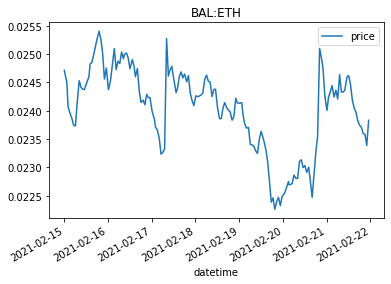

Median BAL:ETH price for the week: 0.024187493536353
BAL reimbursements for the week: 2269.759425959374


In [53]:
from google.cloud import bigquery
from google.cloud import bigquery_storage

if not REALTIME_ESTIMATOR:
    whitelist = pd.read_json(f'https://raw.githubusercontent.com/balancer-labs/assets/w{WEEK}/lists/eligible.json').index.values
    gas_whitelist = pd.Series(whitelist).str.lower().tolist()
#     gas_whitelist = ['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
#                      '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
#                      '0x6b175474e89094c44da98b954eedeac495271d0f',
#                      '0xba100000625a3754423978a60c9317c58a424e3d',
#                      '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599']

    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying Bigquery for eligible swaps and reimbursement values ...')

    sql = '''
    WITH n_swaps as (
        SELECT
            txns.`block_number`,
            txns.`block_timestamp`,
            txns.`from_address`,
            txns.`hash`,
            txns.`receipt_gas_used`,
            txns.`gas_price`,
            count(1) as n_swaps
        FROM `blockchain-etl.ethereum_balancer.BPool_event_LOG_SWAP` swaps
        INNER JOIN `bigquery-public-data.crypto_ethereum.transactions` txns
        ON swaps.transaction_hash = txns.`hash`
        WHERE 1=1
        AND swaps.block_timestamp >= TIMESTAMP_SECONDS({0})
        AND txns.block_timestamp >= TIMESTAMP_SECONDS({0})
        AND swaps.block_timestamp < TIMESTAMP_SECONDS({1})
        AND txns.block_timestamp < TIMESTAMP_SECONDS({1})
        AND txns.to_address = '0x3e66b66fd1d0b02fda6c811da9e0547970db2f21'
        AND swaps.tokenIn IN ('{2}')
        AND swaps.tokenOut IN ('{2}')
        GROUP BY 1,2,3,4,5,6
    ),
    median_gas_prices AS (
        SELECT DISTINCT
            txns.`block_number`,
            PERCENTILE_CONT(txns.`gas_price`, 0.5) OVER(PARTITION BY txns.`block_number`) AS block_median_gas_price
        FROM `bigquery-public-data.crypto_ethereum.transactions` txns
        INNER JOIN n_swaps ON txns.block_number = n_swaps.block_number
        WHERE 1=1
        AND txns.block_timestamp >= TIMESTAMP_SECONDS({0})
        AND txns.block_timestamp < TIMESTAMP_SECONDS({1})
        AND txns.`gas_price` > 1000000000
    ),
    reimbursements AS (
        SELECT n.*, m.block_median_gas_price,
        CASE WHEN receipt_gas_used > n_swaps * 100000 THEN n_swaps * 100000 ELSE receipt_gas_used END AS gas_reimbursement,
        CASE WHEN gas_price > block_median_gas_price THEN block_median_gas_price ELSE gas_price END AS reimbursement_price
        FROM n_swaps n 
        INNER JOIN median_gas_prices m
        ON n.block_number = m.block_number
    )

    SELECT
        from_address as address,
        SUM(gas_reimbursement*reimbursement_price)/1E18 as eth_reimbursement 
    FROM reimbursements 
    GROUP BY 1
    ORDER BY 1
    '''.format(start_block_timestamp, end_block_timestamp, '\',\''.join(gas_whitelist))


    client = bigquery.Client()

    bqstorageclient = bigquery_storage.BigQueryReadClient()
    reimbursements = (
        client.query(sql)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')
    print(f'ETH reimbursements for the week: {sum(reimbursements.eth_reimbursement)}')

    # get BAL:ETH price feed from Coingecko
    bal_eth_coingecko = 'https://api.coingecko.com/api/v3/coins/ethereum/contract/0xba100000625a3754423978a60c9317c58a424e3d/market_chart/range?vs_currency=eth&from={0}&to={1}'.format(start_block_timestamp, end_block_timestamp)

    baleth_feed = pd.read_json(bal_eth_coingecko)['prices']
    baleth_feed = pd.DataFrame(baleth_feed.tolist(), index=baleth_feed.index, columns=['timestamp','price'])
    baleth_feed['datetime'] = pd.to_datetime(baleth_feed['timestamp']/1000, unit='s')
    baleth_feed.drop(columns=['timestamp'], inplace=True)
    baleth_feed.set_index('datetime', inplace=True)
    baleth_feed.plot(title='BAL:ETH');
    plt.show()
    print(f'Median BAL:ETH price for the week: {np.median(baleth_feed)}')
    reimbursements['bal_reimbursement'] = reimbursements['eth_reimbursement'] / np.median(baleth_feed)
    reimbursements['address'] = reimbursements['address'].apply(Web3.toChecksumAddress)
    reimbursements.set_index('address', inplace=True)
    reimbursements = reimbursements['bal_reimbursement']
    reimbursements[reimbursements>=CLAIM_THRESHOLD].apply(\
       lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_gasReimbursement.json',
       indent=4)
    print(f'BAL reimbursements for the week: {sum(reimbursements)}')

    # combine BAL from liquidity mining and gas reimbursements
    totals = pd.DataFrame(totals).join(reimbursements, how='outer')
    totals.fillna(0, inplace=True)
    totals['bal_total'] = totals['bal_mined'] + totals['bal_reimbursement']
    totals = totals['bal_total']
    totals[totals>=CLAIM_THRESHOLD].apply(\
       lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_totals.json',
       indent=4)

# Plots

Top 10 tokens:
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
0xba100000625a3754423978a60c9317c58a424e3d
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599
0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
0x6b175474e89094c44da98b954eedeac495271d0f
0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2
0x04fa0d235c4abf4bcf4787af4cf447de572ef828
0x6810e776880c02933d47db1b9fc05908e5386b96
0xbc396689893d065f41bc2c6ecbee5e0085233447


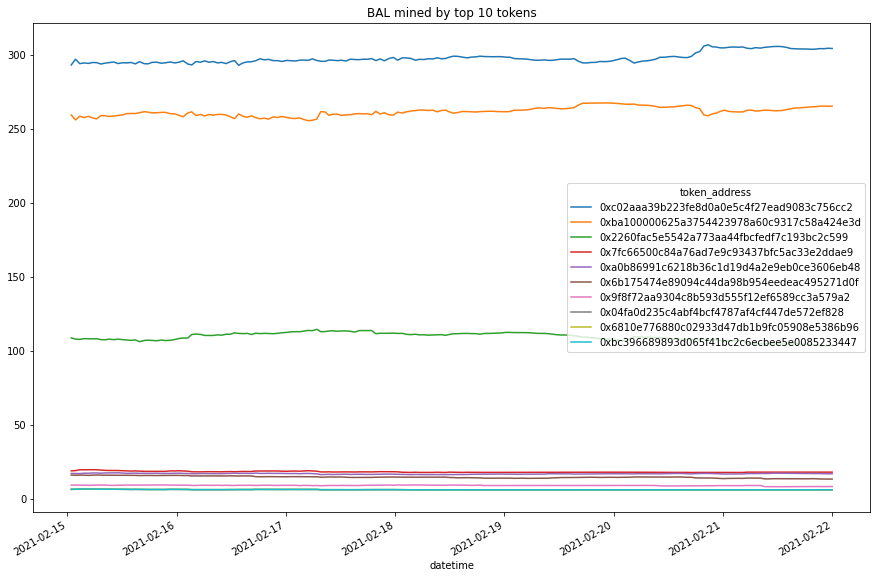

In [54]:
top_tokens = subpools['BAL_mined'].groupby(['token_address']).sum().sort_values(ascending=False).head(10).index
subpools['datetime'] = pd.to_datetime(subpools.timestamp, unit='s')
rewards_per_token = subpools.groupby(['token_address','datetime']).sum()['BAL_mined']
print('Top 10 tokens:\n' + '\n'.join(top_tokens))
if not REALTIME_ESTIMATOR:
    ax = pd.DataFrame(rewards_per_token).reset_index().\
        pivot(index='datetime', columns='token_address', values='BAL_mined')[top_tokens].\
        plot(figsize = (15,10),
             title = 'BAL mined by top 10 tokens')

Top 10 pools:
0x59a19d8c652fa0284f44113d0ff9aba70bd46fb4
0x1eff8af5d577060ba4ac8a29a13525bb0ee2a3d5
0x9dde0b1d39d0d2c6589cde1bfed3542d2a3c5b11
0x8b6e6e7b5b3801fed2cafd4b22b8a16c2f2db21a
0xc697051d1c6296c24ae3bcef39aca743861d9a81
0x221bf20c2ad9e5d7ec8a9d1991d8e2edcfcb9d6c
0xe867be952ee17d2d294f2de62b13b9f4af521e9a
0x6b9887422e2a4ae11577f59ea9c01a6c998752e2
0xe93e8aa4e88359dacf33c491cf5bd56eb6c110c1
0xba20d4f41121b997a1eaca6d938ac40b67dad226


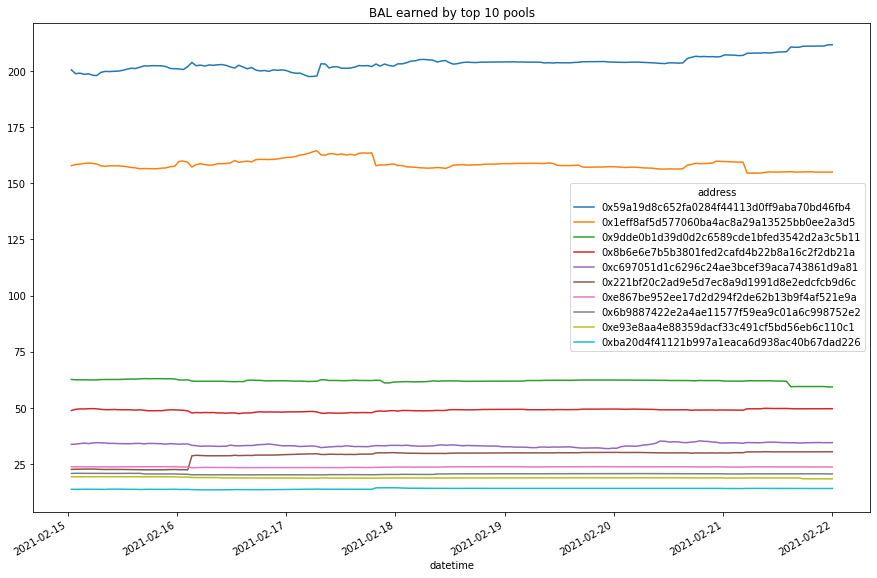

In [55]:
rewards_per_pool = subpools.groupby(['address','datetime']).sum()['BAL_mined']
top_pools = subpools['BAL_mined'].groupby(['address']).sum().sort_values(ascending=False).head(10).index
print('Top 10 pools:\n' + '\n'.join(top_pools))
if not REALTIME_ESTIMATOR:
    ax = pd.DataFrame(rewards_per_pool).reset_index().\
        pivot(index='datetime', columns='address', values='BAL_mined')[top_pools].\
        plot(figsize = (15,10),
             title = 'BAL earned by top 10 pools')


Top 10 LPs:
0xAfC2F2D803479A2AF3A72022D54cc0901a0ec0d6
0x8cA24021E3Ee3B5c241BBfcee0712554D7Dc38a1
0x49a2DcC237a65Cc1F412ed47E0594602f6141936
0x41A08648C3766F9F9d85598fF102a08f4ef84F84
0x6b7Ac46d09d2ADF4CeBe2995EbF9d97E13E9E257
0x97D4B02Ce33C399fFeC618Bfd2D5Bf7108e556ac
0xfF052381092420B7F24cc97FDEd9C0c17b2cbbB9
0xBc79855178842FDBA0c353494895DEEf509E26bB
0xCeCD5557FCC879BfeB4d209eAf646311fC30eFd5
0x6A025e093C6C0c5381d5763283E1dB339ff22Eb6


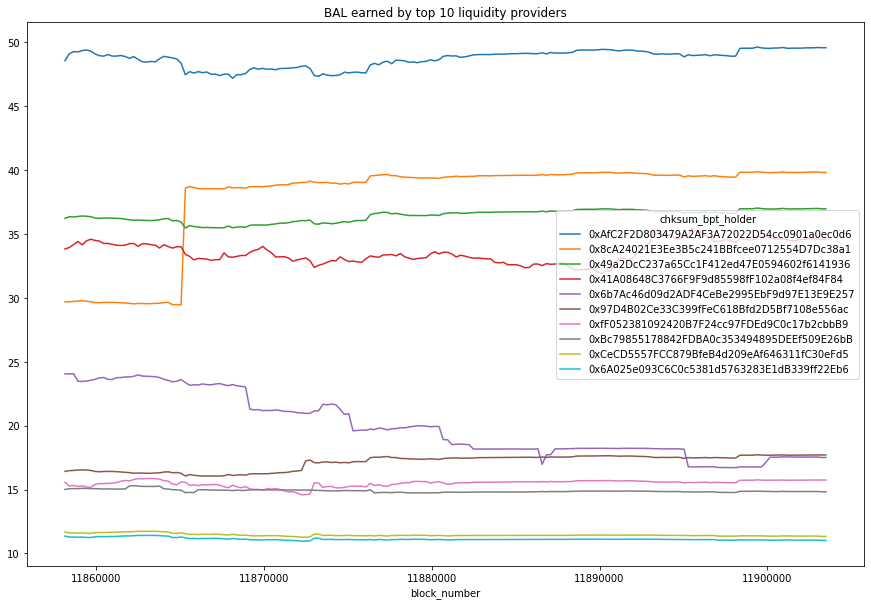

In [56]:
rewards_per_lp = bal_mined['bal_mined'].groupby(['chksum_bpt_holder','block_number']).sum()
top_lps = bal_mined['bal_mined'].groupby(['chksum_bpt_holder']).sum().sort_values(ascending=False).head(10).index
print('Top 10 LPs:\n' + '\n'.join(top_lps))
if not REALTIME_ESTIMATOR:
    ax = pd.DataFrame(rewards_per_lp).reset_index().\
        pivot(index='block_number', columns='chksum_bpt_holder', values='bal_mined')[top_lps].\
        plot(figsize = (15,10),
             title = 'BAL earned by top 10 liquidity providers')
    ax.ticklabel_format(axis='x', style='plain')

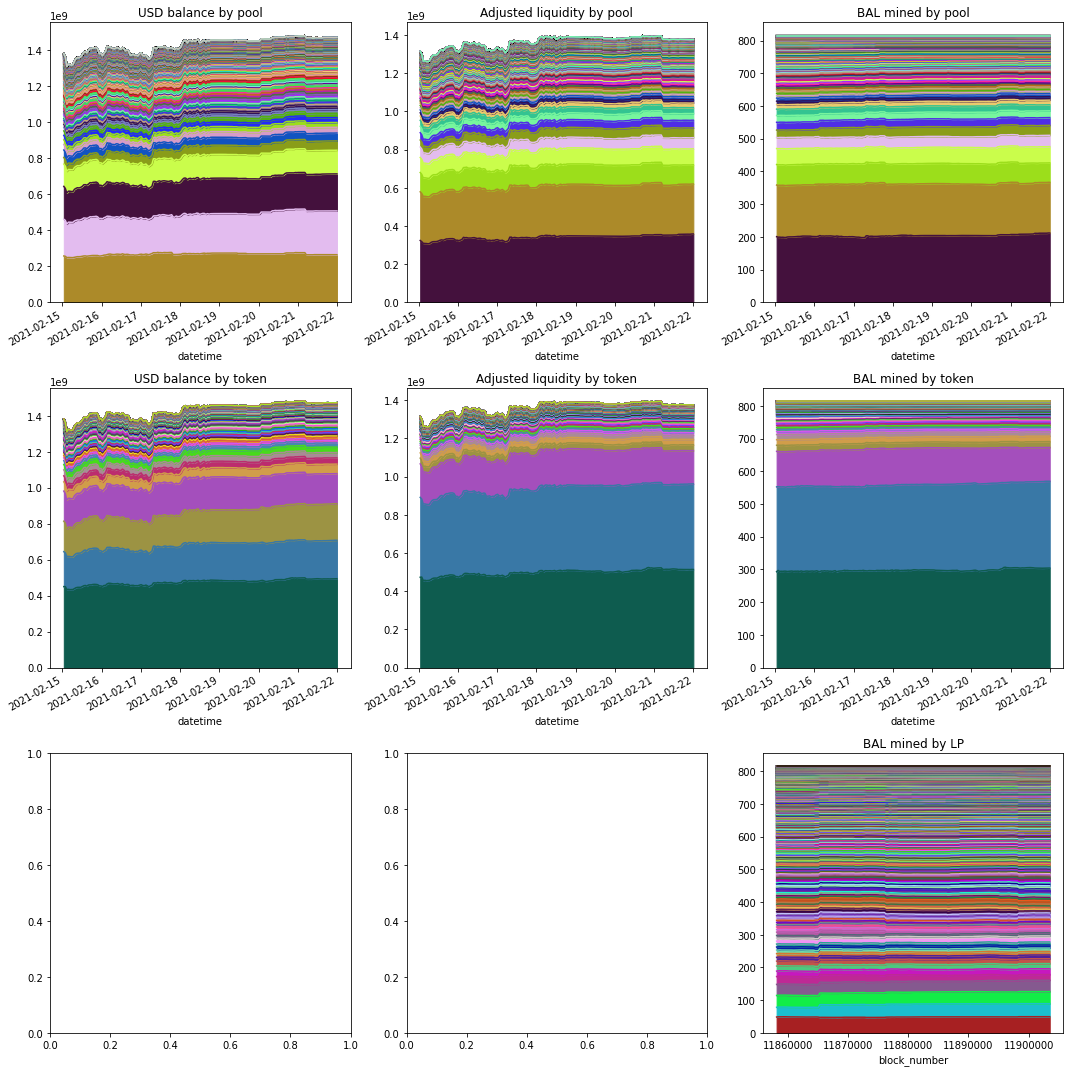

In [57]:
if not REALTIME_ESTIMATOR:
    from matplotlib.colors import ListedColormap
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

    i = 0
    areaplot = subpools.groupby(['datetime','address']).sum().\
                reset_index().pivot(index='datetime', columns='address', values='usd_balance')
    # deterministically color code the regions of the plot for visual inspection between weeks
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='USD balance by pool', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','address']).sum().\
                reset_index().pivot(index='datetime', columns='address', values='finalAdjustedLiquidity')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='Adjusted liquidity by pool', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','address']).sum().\
                reset_index().pivot(index='datetime', columns='address', values='BAL_mined')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='BAL mined by pool', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','token_address']).sum().\
                reset_index().pivot(index='datetime', columns='token_address', values='usd_balance')
    # deterministically color code the regions of the plot for visual inspection between weeks
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='USD balance by token', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','token_address']).sum().\
                reset_index().pivot(index='datetime', columns='token_address', values='finalAdjustedLiquidity')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='Adjusted liquidity by token', colormap=pal)

    i += 1
    areaplot = subpools.groupby(['datetime','token_address']).sum().\
                reset_index().pivot(index='datetime', columns='token_address', values='BAL_mined')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='BAL mined by token', colormap=pal)

    i += 3
    areaplot = bal_mined.groupby(['block_number','chksum_bpt_holder']).sum().\
                reset_index().pivot(index='block_number', columns='chksum_bpt_holder', values='bal_mined')
    areaplot = areaplot[list(areaplot.sum().sort_values(ascending=False).index)]
    pal = ListedColormap(list(map(lambda x: '#'+x[20:26], list(areaplot.columns))))
    areaplot.plot.area(legend=False, ax=axs.flat[i], title='BAL mined by LP', colormap=pal);
    axs.flat[i].ticklabel_format(axis='x', style='plain')

    plt.tight_layout()

Effective govFactor: 1.079 vs 0.981
Additional BAL mined by governors: 2244.404


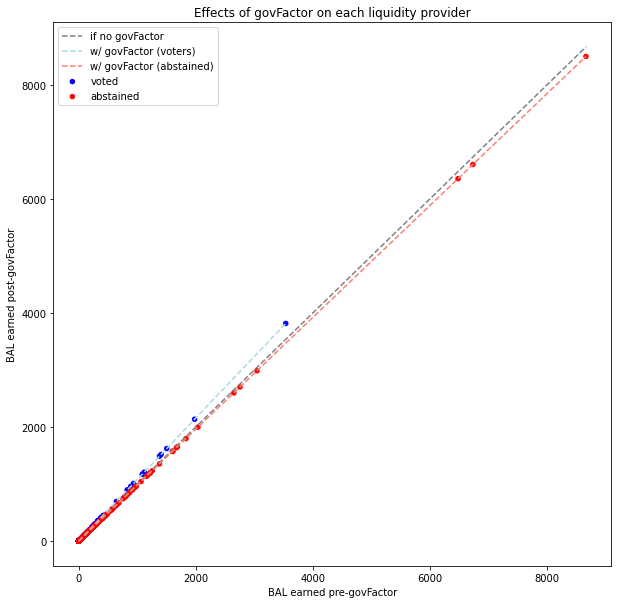

In [58]:
if gov_factor > 1:
    pregov = pd.DataFrame(totals_pre_govfactor)
    pregov.columns= ['pregov']
    postgov = pd.DataFrame(totals_post_govfactor)
    postgov.columns= ['postgov']
    compare = pregov.join(postgov)
    compare['ratio'] = compare['postgov']/compare['pregov']
    compare['voter'] = compare.index.isin(voters)
    compare['color'] = compare['voter'].apply(lambda x: 'blue' if x else 'red')
    effective_gov_factor = compare[compare['voter']]['ratio'].median()
    effective_gov_loss = compare[~compare['voter']]['ratio'].median()
    print(f'Effective govFactor: {effective_gov_factor:.3f} vs {effective_gov_loss:.3f}')
    absolute_increase = (compare[compare['voter']]['postgov'] - compare[compare['voter']]['pregov']).sum()
    print(f'Additional BAL mined by governors: {absolute_increase:.3f}')    
    if not REALTIME_ESTIMATOR:
        ax = compare[compare['voter']].plot.scatter(x='pregov', y='postgov', 
                                                    c='color', figsize=(10,10),
                                                    label='voted'
                                                   )
        compare[~compare['voter']].plot.scatter(x='pregov', y='postgov', 
                                                    c='color', figsize=(10,10),
                                                    label='abstained', ax=ax
                                                   )

        x = compare['pregov']
        y = compare['pregov']
        ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
                color='grey', linestyle='--',
                label = 'if no govFactor')

        x = compare[compare['voter']]['pregov']
        y = compare[compare['voter']]['postgov']
        ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
                color='lightblue', linestyle='--',
                label = 'w/ govFactor (voters)')
        
        x = compare[~compare['voter']]['pregov']
        y = compare[~compare['voter']]['postgov']
        ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
                color='salmon', linestyle='--',
                label = 'w/ govFactor (abstained)')


        ax.set_xlabel('BAL earned pre-govFactor')
        ax.set_ylabel('BAL earned post-govFactor')
        ax.set_title('Effects of govFactor on each liquidity provider')
        ax.legend()

In [59]:
if not REALTIME_ESTIMATOR:
    print('Final Check Totals')
    _lm = pd.read_json(reports_dir+'/_totalsLiquidityMining.json', orient='index').sum().values[0]
    _claim = pd.read_json(reports_dir+'/_totals.json', orient='index').sum().values[0]
    print(f'Liquidity Mining: {format(_lm, f".{CLAIM_PRECISION}f")}')
    print(f'Gas Reimbursement: {format(_claim-145000, f".{CLAIM_PRECISION}f")}')
    print(f'Total: {format(_claim, f".{CLAIM_PRECISION}f")}')

Final Check Totals
Liquidity Mining: 145000.000000000000000000
Gas Reimbursement: 2269.759425959375221282
Total: 147269.759425959375221282
